In [2]:
import asyncio
import time
import math
import numpy as np
from cv2 import VideoCapture
import matplotlib.pyplot as plt
from matplotlib import colors
import Global
# from vision.module import detection, utils, constants
# from vision.functions import vision_init, get_thymio
from vision.functions import vision_init, get_thymio
# import vision_nav
import KF
from Control import Control
import cv2

In [3]:

#Connecting to the tymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node c840c803-5e0f-416f-ae5d-a54e0adeec35

In [4]:
thymio = Control(node,client)

init


In [59]:
aw(node.unlock())

In [5]:
thymio.set_motors(0,"forward")

Going forward


In [6]:
ls,rs,prox = await thymio.get_sensors()
display(ls)
display(rs)
display(prox)

46

49

[0, 0, 2745, 3374, 3487, 0, 0]

In [7]:
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))

In [3]:
# lock the camera resource
cap = VideoCapture(0)

In [4]:

#ret, img = cap.read()
#cv2.imshow("test", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#  allocate variables
grid = None
obs = []
obs_grid = None
targets = []
goal = []

# import constants
from vision.constants import grid_height_cells

In [11]:
#  vision initialization

flag, grid, obs, obs_grid, targets, goal = vision_init(cap)
if not flag:
    assert 0

# if you get to this point, the vision is initialized and you have acquired information about the environment

------------------
grid_extraction: markers found
IDS:
[[4]
 [5]
 [1]
 [3]
 [2]]
------------------


In [5]:
display(obs_grid)

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [7]:
display(targets)

[[0, 2]]

In [11]:
display(goal)

[[5, 3]]

In [4]:
!python -m pip install tk-tools

In [6]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

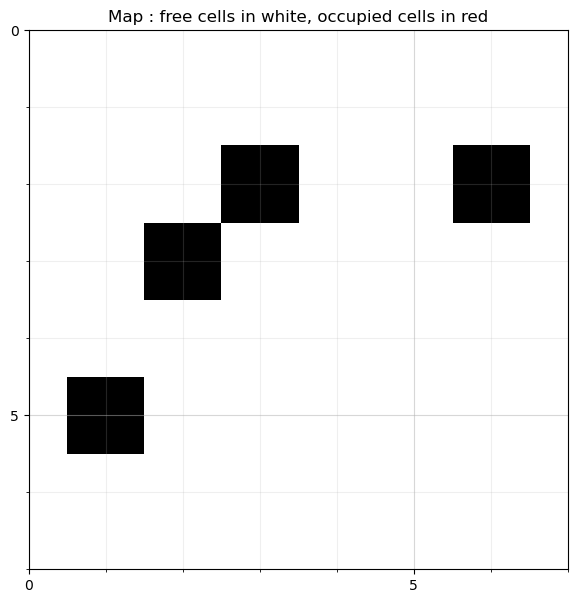

In [12]:
max_val = grid_height_cells  # here, we suppose a squared environment
fig, ax = create_empty_plot(max_val)

# set plot origin to top left 
plt.xlim(0, max_val)
plt.ylim(max_val, 0)

# Displaying the map
cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(obs_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")

In [ ]:
'''
# OLD VERSION
#Creating the grid
max_val = 12 # Size of the map

fig, ax = create_empty_plot(max_val)

# Creating the occupancy grid
np.random.seed(5) # To guarantee the same outcome on all computers
data = np.random.rand(max_val, max_val)*20 # Create a grid of 50 x 50 random values, a matrix 50*50
cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells
# Converting the random values into occupied and free cells
limit = 17
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");
'''

In [13]:
# List of all coordinates in the grid
#max_val is the size of the map
#x: 2D array where each element x[i, j] represents the x coordinate at position (i, j) in the grid.
#Donc x[1,n] rendra toujours 1 car la coord x d'un point en (1,n) est 1
#y: 2D array where each element y[i, j] represents the y coordinate at position (i, j) in the grid.
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
#Coords countains all the possible coordinates of the grid from (0,0) to (max_val-1,max_val-1)
coords = list([(int(x[0]), int(x[1])) for x in pos])

#Defining the start  point and end goal for now on
flag, _,state = get_thymio(cap)
if flag:
    start = [state[0],state[1]]
    angle = state[2]
else:
    print("Problem with thymio_get function")
    
display(start)

------------------
thymio_recognition: markers found
IDS:
[[4]
 [5]
 [2]
 [1]
 [3]]
------------------


[3.413, 1.761]

In [14]:
#Defining the distance to the goal ignoring the obstacles, here using the Euclidian distance with the function np.linalg.norm
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

ValueError: operands could not be broadcast together with shapes (49,2) (2,2) 

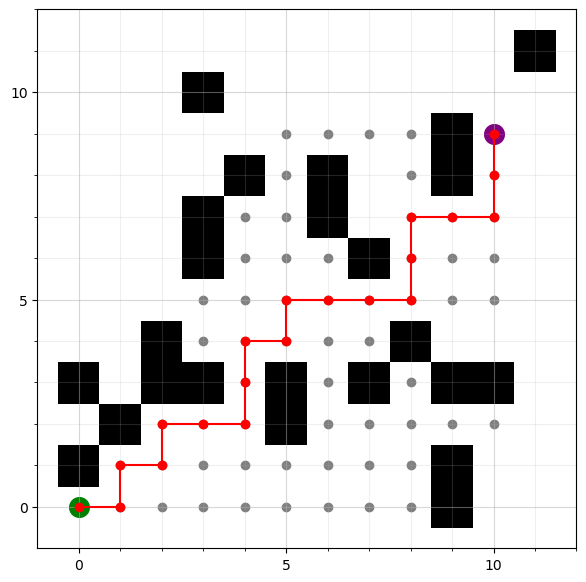

In [14]:
# Run the A* algorithm
path, visitedNodes = Global.A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N") # changed occupancy_grid by grid
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap) # changed occupancy_grid by grid

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'grey')
ax_astar.plot(path[0], path[1], marker="o", color = 'red')
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200)

In [15]:
#Main 
index = 0
size_path = len(path[0])
old_pos = start
target = path[:][0]
epsilon = 0.2
Kidnapping_threshold = 4
while size_path > index: 
    #Checking the state of camera
    camera_on = True
    # try:
    #     _, _, state = get_thymio(cap)
    # except Exception as e:
    #     print("Problem with vision_nav function",e)
    #     camera_on = False

    flag, _, state = get_thymio(cap)
    if not flag:
        print("Problem with vision_nav function")
        camera_on = False
    else:
        pos = [state[0],state[1]]
        angle = state[2]

    #Motor speed
    #tymio = Control_tymio(node,client)
    #print(tymio)
    #tymio.sync()
    speed_left, speed_right, prox = thymio.get_sensors()
    speed = [speed_left,speed_right]
    print(speed)
    if ~camera_on:
        #Kalmann
        tracker = KF.KalmanFilter()
        speed_xy,orientation_est = tracker.compute_x_y_speed(speed[0],speed[1])
        x_est = [pos[-1][0],pos[-1][1],speed_xy[0],speed_xy[1]]
        P_est = np.eye(4)*1000
        pos,speed,angle,x_est,P_est = tracker.predict(speed[0],speed[1],orientation_est,x_est,P_est)
        
        #calculer la norm old pos vs pos --> si superieur a treshold kidnapping
        distance = math.sqrt((pos[0] - old_pos[0])**2 + (pos[1] - old_pos[1])**2)
        if distance > Kidnapping_threshold:
            #Need to initialize kidnapping_threshold with a value
            #recompute vision to get the new position-> this new position is the new start point, the goal remain unchanged
            flag, _, state = get_thymio(cap)
            if flag:
                pos = [state[0],state[1]]
                angle = state[2]
            else:
                print("Problem with thymio_get function")
            path, visitedNodes = Global.A_Star(start, goal, h, coords, grid, movement_type="4N")
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
            index = 0 #The index need to be re-initialized since we have a new path
            
        #Check if robot has arrived at target, and update it if yes
        for idx in range(len(path)):
            if(np.norm(pos[0] == path[idx][0] and pos[1] == path[idx][1]) < epsilon):
                index = idx
                target = path[:][idx+1]
            
        #start leds and sound
        
        #Function obstacle check to implement
        obstacle_detected = False
        #Need to add obstacle avoidance
    
        #Motion control
        #Take into account the KF variable here no ?
        thymio.following_path(pos,angle,target)
        
            

NameError: name 'cap' is not defined

In [1]:
# release the camera resource
cap.release()

NameError: name 'cap' is not defined